# Объявление используемых функций


In [3]:
import json
import pyarrow.parquet as pq
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial import distance_matrix
from matplotlib.colors import ListedColormap

def from_parquet():
    '''
    reading data from 3 parquet tables and joining them together using chosen indexes
    returns joined table
    '''
    
    table1 = pd.read_parquet('data_parquet/sales.parquet', 
                             columns=['date', 'shop_id', 'owner', 'number_of_counters',
                                      'goods_type', 'total_items_sold',],
                              engine='pyarrow' )

    table2 = pd.read_parquet('data_parquet/shops.parquet', 
                             columns=['shop_id', 'neighborhood', 'city',
                                      'year_opened', 'is_on_the_road', 'is_with_the_well',
                                      'is_with_additional_services', 'shop_type', ],
                              engine='pyarrow' )

    table3 = pd.read_parquet('data_parquet/cities.parquet', engine='pyarrow' )

    table1 = pd.DataFrame(table1)
    table2 = pd.DataFrame(table2)
    table3 = pd.DataFrame(table3)
    table23 = table2.join(table3.set_index('city'), on='city')
    full_table = table23.join(table1.set_index('shop_id'))
    return full_table


def process_empty_fields(table):
    '''
    replaces NaN fields with string 
    returns filled table
    '''
    table = table.fillna({"is_on_the_road": "неизвестно"})
    table = table.fillna({"is_with_the_well": "неизвестно"})
    table = table.fillna({"is_with_additional_services": "неизвестно"})
    table = table.fillna({"shop_type" : "неизвестно"})
    table = table.fillna({"location" : "неизвестно"})
    table = table.fillna({"city" : "неизвестно"})
    table = table.loc[table['year_opened'] != -1]
    return table


def change_type(table, col_name):
    '''changes type of input table`s column to a str'''
    
    column = table[col_name].copy()
    column = str(column)
    table[col_name] = column
    return table


def replace_string_columns(table):
    '''
    takes table with object fields as an input and encodes them to an integer values
    returns table and dictionary with values, which will be needed to decode integer fields
    '''
    
    obj_df = table.select_dtypes(include=['object']).copy()
    new_dict = dict()
    col_names = [col_name for col_name in obj_df]
    col_names.append('date')
    for col in col_names:
        if col == "shop_id":
            continue
        new_dict.update({col: {n: cat for n, cat in enumerate(table[col].astype('category').cat.categories)}})
        table[col] = table[col].astype('category')
        table[col] = table[col].cat.codes
    return table, new_dict


def normalize_column(table, col_name):
    '''applies min-max normalization to a column: col_name in a table'''
    column = table[col_name].copy()
    normalized_col = (column-column.min())/(column.max()-column.min())
    table[col_name] = normalized_col
    return table


def plot_clusters(table, labels_dictionary, x_features, num_feautures, features_to_discover):
    
    for x_feature in x_features:
        for y_feature in features_to_discover:
            if y_feature == x_feature:
                continue
            fig, ax = plt.subplots()
            plt.xlabel(x_feature)
            plt.ylabel(y_feature)

            colours = ListedColormap(['crimson', 'darkviolet', 'mediumblue', 'green', 'deepskyblue', 'goldenrod'])
            classes = [x for x in range(3)]

            scatter = plt.scatter(table.loc[:, x_feature], table.loc[:, y_feature], c=table.loc[:, 'cluster_id'], 
                                 s=15, cmap=colours)
            plt.legend(handles=scatter.legend_elements()[0], labels=classes)
            
            # необходимо декодирование, так как это строковый признак
            if y_feature not in num_feautures:
                all_values = labels_dictionary[y_feature]
                position = np.arange(len(labels_dictionary[y_feature]))
                ax.set_yticks(position)
                values = [all_values[n] for n in all_values]
                labels = ax.set_yticklabels(values,
                               fontsize = 10,    #  Размер шрифта
                               color = 'rebeccapurple',    #  Цвет текста
                               rotation = 0,    #  Поворот текста
                               verticalalignment =  'center')

            if x_feature not in num_feautures:
                position = np.arange(len(labels_dictionary[x_feature]))
                ax.set_xticks(position)
                all_values = labels_dictionary[x_feature]
                values = [all_values[n] for n in all_values]
                labels = ax.set_xticklabels(values,
                               fontsize = 10,    #  Размер шрифта
                               color = 'indigo',    #  Цвет текста
                               rotation = 80,    #  Поворот текста
                               verticalalignment =  'top')

Загрузим наши таблицы, заполним пустые поля, закодируем строковые значения целочисленными и выведем результат

In [4]:
table = from_parquet()  # load tables and joining together
table = process_empty_fields(table)  # replace empty fields, delete rows with year_opened=-1 
table, labels_dictionary = replace_string_columns(table)  # change object values to int
table = normalize_column(table, 'total_items_sold')  # min-max scaler for total_items_sold column
table.head(3)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,location,date,owner,number_of_counters,goods_type,total_items_sold
0,705,0,4,2109,1,0,0,0,2,0,3,4,8,0.023815
0,705,0,4,2109,1,0,0,0,2,0,3,4,9,0.023895
0,705,0,4,2109,1,0,0,0,2,0,3,4,0,0.065888


Количество элементов, записанных в словарь для декодирования

In [3]:
len(labels_dictionary)

10

Количество уникальных значений в каждом столбце

In [4]:
for col_name in table:
  print("{} ---> {} unique values".format(col_name, table[col_name].nunique()))

shop_id ---> 782 unique values
neighborhood ---> 7 unique values
city ---> 16 unique values
year_opened ---> 55 unique values
is_on_the_road ---> 2 unique values
is_with_the_well ---> 3 unique values
is_with_additional_services ---> 3 unique values
shop_type ---> 5 unique values
location ---> 4 unique values
date ---> 730 unique values
owner ---> 5 unique values
number_of_counters ---> 23 unique values
goods_type ---> 11 unique values
total_items_sold ---> 64594 unique values


Считываем все столбцы в таблице и выбираем те, которые будут задействованы для обучения

In [5]:
all_columns = [n for n in table]
train_columns = ['neighborhood', 'city', 'year_opened', 'is_on_the_road', 
                  'is_with_the_well', 'is_with_additional_services', 
                  'shop_type', 'location', 'number_of_counters',
                  'goods_type', 'total_items_sold']

Количество строк:

In [6]:
table.shape[0]

4694733

Количество магазинов:

In [7]:
table['shop_id'].nunique()

782

Из-за большого количества строк проведем кластеризацию в цикле для каждого магазина (shop_id) с использованием агломеративной кластеризации.
В качестве критерия связи linkage используем метод ward.
Количество кластеров равно 3 из предположения, что магазины могут быть разделены на крупные, средние и маленькие.


In [8]:
# small_table = table[30000:40000]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

tab = pd.DataFrame(columns = all_columns)

tab['cluster_id'] = None
max_days = table['date'].nunique()


for n in range(0, max_days):
    small_table = pd.DataFrame()
    small_table = table.loc[table['date'] == n]
    chosen_table = small_table.loc[:, train_columns]
    transformed_table = scaler.fit_transform(chosen_table)
    clustering = AgglomerativeClustering(linkage="ward", n_clusters=3).fit(transformed_table)
    final = small_table.copy()
    final['cluster_id'] = clustering.labels_

    tab = tab.append(final)
tab




,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,location,date,owner,number_of_counters,goods_type,total_items_sold,cluster_id
0,705,0,4,2109,1,0,0,0,2,0,3,4,8,0.023815,2
0,705,0,4,2109,1,0,0,0,2,0,3,4,9,0.023895,2
0,705,0,4,2109,1,0,0,0,2,0,3,4,0,0.065888,2
1,601,0,10,2137,1,2,2,3,2,0,3,5,8,0.023859,0
1,601,0,10,2137,1,2,2,3,2,0,3,5,9,0.023827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,289,0,4,2133,1,2,0,2,2,729,3,10,2,0.023999,0
844,289,0,4,2133,1,2,0,2,2,729,3,10,5,0.024119,0
844,289,0,4,2133,1,2,0,2,2,729,3,10,1,0.023867,0
844,289,0,4,2133,1,2,0,2,2,729,3,10,0,0.195867,0


Необходимо чтобы каждому магазину (shop_id) был присвоен только один кластер. Обработаем полученные данные для поиска наиболее часто встречающегося кластера в рамках рассмотрения каждого магазина.

In [9]:
res_table = pd.DataFrame(columns = all_columns)
res_table['cluster_id'] = None
max_shops = tab['shop_id'].nunique()

for n in range(0, max_shops):
    shops_table = pd.DataFrame()
    shops_table = tab.loc[tab['shop_id'] == n]
    if shops_table.empty:
        continue
    max_probable_cluster = shops_table['cluster_id'].value_counts().idxmax()
    res = shops_table.copy()

    res['cluster_id'] = max_probable_cluster
    res_table = res_table.append(res)

res_table

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type,location,date,owner,number_of_counters,goods_type,total_items_sold,cluster_id
259,0,0,6,2136,1,2,2,4,1,0,3,6,3,0.023855,0
259,0,0,6,2136,1,2,2,4,1,0,3,6,10,0.023907,0
259,0,0,6,2136,1,2,2,4,1,0,3,6,8,0.024650,0
259,0,0,6,2136,1,2,2,4,1,0,3,6,6,0.025729,0
259,0,0,6,2136,1,2,2,4,1,0,3,6,9,0.024003,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,781,1,2,2140,1,2,0,0,0,729,3,5,9,0.024363,2
610,781,1,2,2140,1,2,0,0,0,729,3,5,5,0.024395,2
610,781,1,2,2140,1,2,0,0,0,729,3,5,1,0.026404,2
610,781,1,2,2140,1,2,0,0,0,729,3,5,0,0.109460,2


Вывод зависимостей двух признаков с изображением соответствующих кластеров. Для строковых признаков выполняется декодирование значений для корректного отображения значений по осям

Зададим признаки, которые хотим исследовать и выведем на экран зависимости

c:\users\aliev\appdata\local\programs\python\python37\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


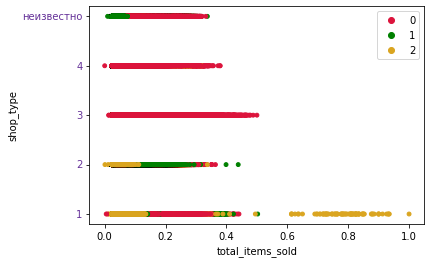

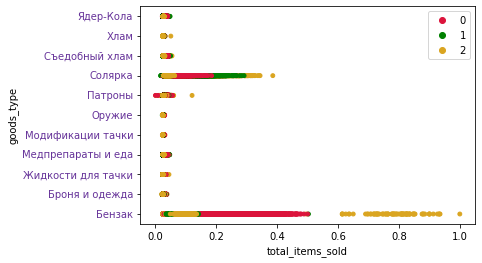

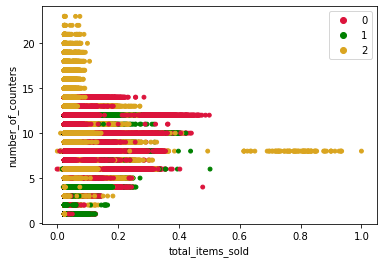

c:\users\aliev\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


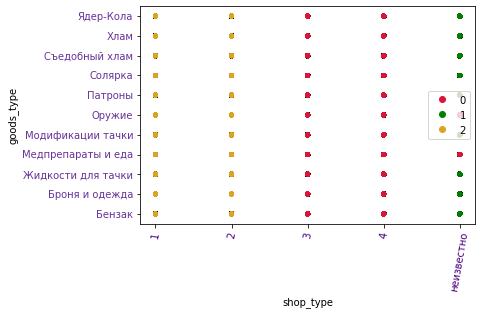

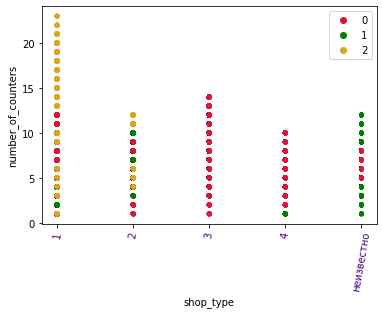

In [10]:
x_features =  ['total_items_sold', 'shop_type']  # признаки по оси x
numeric_feautures = ['total_items_sold', 'year_opened', 'number_of_counters']  # количественные признаки
features_to_discover = ['shop_type', 'goods_type', 'number_of_counters']  # признаки по оси y
    
plot_clusters(res_table, labels_dictionary, x_features, numeric_feautures, features_to_discover)



Сохранение результатов кластеризации в файл

In [11]:
t = res_table.copy()
cols_to_save = ['shop_id', 'cluster_id']
tab_to_save = pd.DataFrame(columns=cols_to_save)
for col in cols_to_save:
    tab_to_save[col] = t[col]
tab_to_save.to_csv("results_table.tsv", index=False, sep="\t")



Вывод диаграммы

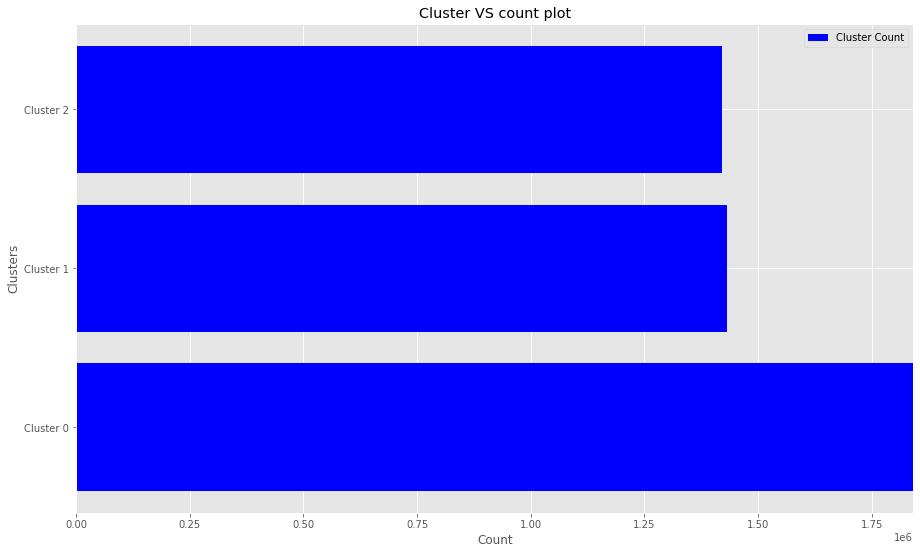

In [12]:
# final.groupby(["cluster", "total_items_sold"])["cluster"].size().unstack()
res_table.groupby(["cluster_id", "shop_id"])["cluster_id"].size().unstack() 
temp = tab.groupby(["cluster_id"])["cluster_id"].count()

temp
plt.style.use("ggplot")
plt.figure(figsize=(15,9))
plt.barh([0, 1, 2], temp.values, label = "Cluster Count", color="b" )
plt.ylabel("Clusters")
plt.xlabel("Count")
plt.title("Cluster VS count plot")
plt.xlim(0, temp.values.max())
plt.yticks([0, 1, 2], ["Cluster 0", "Cluster 1", "Cluster 2"])
plt.legend()
plt.show()